# Projeto - Predição do Dataset House Prices

O *Dataset House Prices* contém uma série de atributos categóricos/numéricos e uma variável-objetivo: *SalePrice*. Este projeto tem como objetivo implementar modelos de regressão pata estimar o preço de residências com base nos dados que as descrevem.

A pipeline implementada é simples: Ingestão dos dados, análise exploratória, *feature engineering* e modelos de aprendizado.

1. Ingestão dos Dados: os dados de treinamento e de teste constam em arquivos csv disponiblizados pela plataforma *Kaggle*. Além disso, um *benchmark* de uma regressão linear sobre os atributos: *year*, *month of sale*, *Lot square footage* e *number of bedrooms*, também é fornecido pela *Kaggle*.

2. Análise Exploratória: Nesta etapa, serão gerados gráficos das distribuições do *House Prices*, bem como análises estatíscas simples que indicarão possíveis alterações nos atributos, a fim de facilitar o aprendizado dos modelos a serem treinados.

3. Filtragem e Tratamento dos Dados: Normalização *z-score*, mapeamento de dados numéricos em categóricos, agrupamento, substituição de dados faltantes.

4. Modelos de Aprendizado: será realizada uma busca em rede de modelos Multilayer Perceptron, variando-se hiperparâmetros e algoritimos de aprendizado. O desempenho dos modelos será comparado com a regressão linear *benchmark* fornecida pela *Kaggle*.

As etapas não são sequenciais. 


### Ingestão dos Dados


In [329]:
# Importando Bibliotecas
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
sbn.set_style("whitegrid")

In [330]:
# Dados de Treinamento e de Teste
train_data = pd.read_csv("./data/train.csv")
test_data = pd.read_csv("./data/test.csv")
print(f"Train Shape: {train_data.shape}, Test Shape:{test_data.shape}")

Train Shape: (1460, 81), Test Shape:(1459, 80)


### Tratamento dos Dados

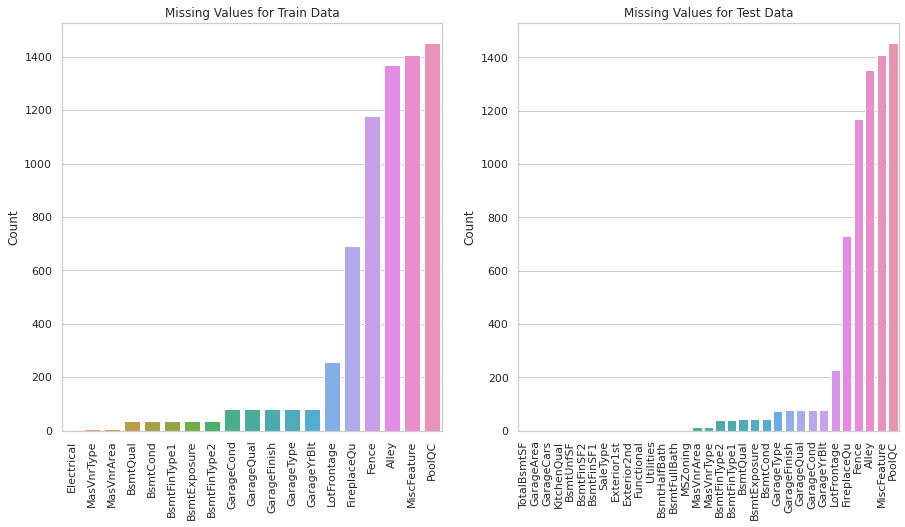

In [331]:
# Células NaN
def get_missing_values(df):
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    missing_values.sort_values(inplace=True)
    
    return missing_values

missing_train = get_missing_values(train_data)
missing_test = get_missing_values(test_data)

# Visualizando Dados Faltantes
fig, ax = plt.subplots(1, 2)

bar_train = sbn.barplot(x=missing_train.index, y=missing_train, ax=ax[0])
bar_test = sbn.barplot(x=missing_test.index, y=missing_test, ax=ax[1])

bar_train.set(title="Missing Values for Train Data", ylabel="Count")
bar_test.set(title="Missing Values for Test Data", ylabel="Count")

bar_train.set_xticklabels(labels=missing_train.index, rotation=90)
bar_test.set_xticklabels(labels=missing_test.index, rotation=90)

fig.set_figwidth(15)
fig.set_figheight(7.5)
fig.savefig("./images/missingValuesTrainTest-I.jpg")

---
**Observação**: O arquivo de descrição dos dados, *data_description.txt*, indica que alguns atributos podem assumir valores NAN, representando ausência da característica e não ausência de informação. Por exemplo: os atributos 'PoolQC' e 'Alley' ao assumirem valores NAN indicam que a casa não tem piscina e não tem via de acesso.

Um mapeamento é aplicado sobre os atributos com células NAN, substituindo-as por strings mais representativas, à exemplo:
1. PoolQC: 
    NAN <-> "no pool"
2. Alley: 
    NAN <-> "no alley acess"


In [332]:
# Mapeamento: Dados não estam faltando, indicam ausência de característica.
values = {
    "PoolQC": "No Pool",
    "MiscFeature": "No Feature",
    "Alley": "No alley access",
    "Fence": "No Fence",
    "FireplaceQu": "No Fireplace",
    "GarageCond": "No Garage",
    "GarageType": "No Garage",
    "GarageYrBlt": "None built",
    "GarageFinish": "No Garage",
    "GarageQual": "No Garage",
    "BsmtExposure": "No Basement",
    "BsmtFinType2": "Not Applicable",
    "BsmtFinType1": "Not Applicable",
    "BsmtCond": "No Basement",
    "BsmtQual": "No Basement",
    "MasVnrType": "No Veneer",
}

train_data.fillna(value=values, inplace=True)
test_data.fillna(value=values, inplace=True)

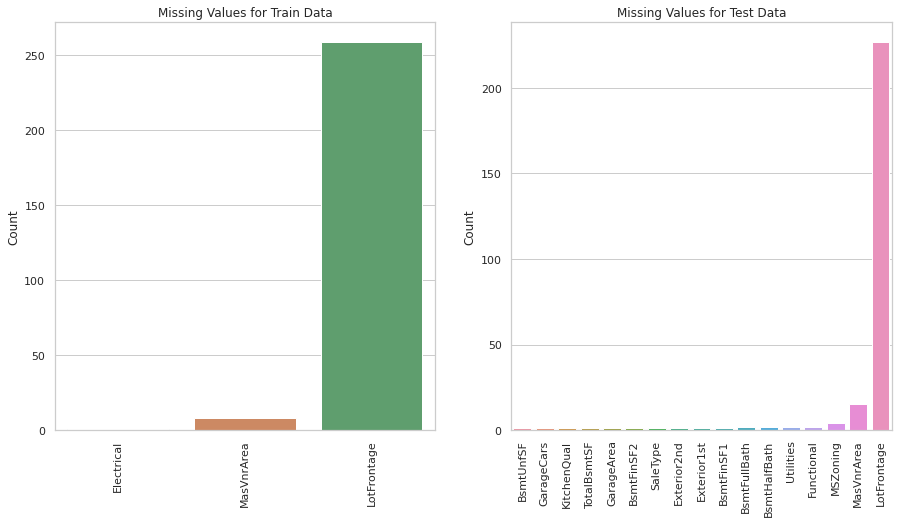

In [333]:
missing_train = get_missing_values(train_data)
missing_test = get_missing_values(test_data)

# Visualizando Dados Faltantes
fig, ax = plt.subplots(1, 2)

bar_train = sbn.barplot(x=missing_train.index, y=missing_train, ax=ax[0])
bar_test = sbn.barplot(x=missing_test.index, y=missing_test, ax=ax[1])

bar_train.set(title="Missing Values for Train Data", ylabel="Count")
bar_test.set(title="Missing Values for Test Data", ylabel="Count")

bar_train.set_xticklabels(labels=missing_train.index, rotation=90)
bar_test.set_xticklabels(labels=missing_test.index, rotation=90)

fig.set_figwidth(15)
fig.set_figheight(7.5)
fig.savefig("./images/missingValuesTrainTest-II.jpg")

---
O mapeamento acima eliminou grande parte das células vazias. Os gráfico de barra revelam que os atributos *LotFrontage* e *MasVnrArea* ainda permanecem com um número relevante de dados faltantes. Abaixo será implementado um modelo KNN para essas duas variáveis, estimando os valores dos dados faltantes com base na proximidade das amostras vizinhas. Para o restante dos atributos, será aplicada uma substituição simples pela moda.

In [334]:
# Filtragem de Dados Faltantes pela moda: excetuando LotFrontage e MasVnrArea
mode_features = set(missing_test.index).union(set(missing_train.index)) - {'LotFrontage', 'MasVnrArea'}
for feature in mode_features:
    train_data[feature].fillna(train_data[feature].mode()[0], inplace=True)
    test_data[feature].fillna(test_data[feature].mode()[0], inplace=True)


In [335]:
# Lidando com dados faltantes a partir do modelo KNN
from externalCode import knn_impute as KNN
def handling_missing_knn(df, feature):
    s = KNN.knn_impute(target=df[feature], attributes=df.drop([feature, 'Id'], 1),
                                        aggregation_method="median", k_neighbors=10, numeric_distance='euclidean',
                                        categorical_distance='hamming', missing_neighbors_threshold=0.8)
    return s
    
train_data["LotFrontage"] = handling_missing_knn(train_data, "LotFrontage")
train_data["MasVnrArea"] = handling_missing_knn(train_data, "MasVnrArea")
test_data["LotFrontage"] = handling_missing_knn(test_data, "LotFrontage")
test_data["MasVnrArea"] = handling_missing_knn(test_data, "MasVnrArea")

In [336]:
# Não há mais células vazias
missing_train = get_missing_values(train_data)
missing_test = get_missing_values(test_data)
print(f"Empty Cells Train: {missing_train.shape[0]}, Empty Cells Test: {missing_test.shape[0]}")

Empty Cells Train: 0, Empty Cells Test: 0


In [337]:
# Descrição dos dados
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

---
Alguns atributos numéricos tem poucos valores únicos, alta discretização. Durante o treinamento, essas variáveis devem ser tratadas como categóricas, aplicando-se *One Hot Encode*. A fim de evitar confusão entre nomes de colunas, os valores númericos serão mapeados para strings, seguindo a indicação dos dados de descrição: *data_description.txt*. Além disso, variáveis numéricas que não apresentam correspondência em strings descritivas serão categorizadas pela função *group_numeric_feature*.

In [338]:
# Mapeamento de Variáveis Numéricas com poucos Valores Únicos

def group_numeric_feature(df, feature, step):
    values = df[feature].values.tolist()
    min_value, max_value = min(values), max(values)
    
    return [f"{feature}: {(value-min_value)//step}" for value in values]
  
def convert_numeric_to_categorical(df, feature):
    values = df[feature].values.tolist()
    
    return [f"{feature}: {int(value)}" for value in values]

group_features = {"YearBuilt":20, "YearRemodAdd":15}
numeric_categorical_fetures = ["BsmtFullBath","BsmtHalfBath",
                               "FullBath", "HalfBath",
                               "BedroomAbvGr","KitchenAbvGr",
                               "TotRmsAbvGrd","Fireplaces", "GarageCars", "MoSold", "YrSold"]

for feature, step in group_features.items():
    train_data[feature] = group_numeric_feature(train_data, feature, step)
    test_data[feature] = group_numeric_feature(test_data, feature, step)

for feature in numeric_categorical_fetures:
    train_data[feature] = convert_numeric_to_categorical(train_data, feature)
    test_data[feature] = convert_numeric_to_categorical(test_data, feature)
    
    MSSUbCLass = {
    20: "1-STORY 1946 & NEWER ALL STYLES",
    30: "1-STORY 1945 & OLDER",
    40: "1-STORY W/FINISHED ATTIC ALL AGES",
    45: "1-1/2 STORY - UNFINISHED ALL AGES",
    50: "1-1/2 STORY FINISHED ALL AGES",
    60: "2-STORY 1946 & NEWER",
    70: "2-STORY 1945 & OLDER",
    75: "2-1/2 STORY ALL AGES",
    80: "SPLIT OR MULTI-LEVEL",
    85: "SPLIT FOYER",
    90: "DUPLEX - ALL STYLES AND AGES",
    120: "1-STORY PUD (Planned Unit Development) - 1946 & NEWER",
    150: "1-1/2 STORY PUD - ALL AGES",
    160: "2-STORY PUD - 1946 & NEWER",
    180: "PUD - MULTILEVEL - INCL SPLIT LEV/FOYER",
    190: "2 FAMILY CONVERSION - ALL STYLES AND AGES",
}

OverallQualCond = {
    10: "Very Excellent",
    9: "Excellent",
    8: "Very Good",
    7: "Good",
    6: "Above Average",
    5: "Average",
    4: "Below Average",
    3: "Fair",
    2: "Poor",
    1: "Very Poor",
}


train_data.replace(
    {
        "OverallQual": OverallQualCond,
        "OverallCond": OverallQualCond,
        "MSSubClass": MSSUbCLass,
    },
    inplace=True,
)
train_data.replace(
    {
        "OverallQual": OverallQualCond,
        "OverallCond": OverallQualCond,
        "MSSubClass": MSSUbCLass,
    },
    inplace=True,
)



In [339]:
# One Hot Encode
def match_dummies(df1, df2):
    # Adicionas features de df1 em df2
    rows = df2.shape[0]
    features = set(df1.columns.unique()) - set(df2.columns.unique())
    print(f"Diff Features:\n{features}\n\n")
    
    for feature in features:
        df2[feature] = np.zeros(shape=(rows, 1))

train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

match_dummies(train_data, test_data)
match_dummies(test_data, train_data)
test_data = test_data[train_data.columns.values.tolist()]

print(f"train shape: {train_data.shape}, test shape: {test_data.shape}")

Diff Features:
{'OverallCond_Above Average', 'OverallQual_Below Average', 'OverallQual_Excellent', 'OverallQual_Very Good', 'OverallQual_Fair', 'Condition2_RRAn', 'MSSubClass_SPLIT FOYER', 'MSSubClass_1-1/2 STORY FINISHED ALL AGES', 'MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES', 'RoofMatl_Membran', 'SalePrice', 'GarageQual_Ex', 'Condition2_RRAe', 'MSSubClass_1-STORY 1946 & NEWER ALL STYLES', 'OverallQual_Above Average', 'OverallCond_Poor', 'MSSubClass_2-STORY PUD - 1946 & NEWER', 'MSSubClass_2-STORY 1945 & OLDER', 'OverallCond_Very Poor', 'OverallCond_Good', 'HouseStyle_2.5Fin', 'BedroomAbvGr_BedroomAbvGr: 8', 'OverallCond_Below Average', 'MSSubClass_2 FAMILY CONVERSION - ALL STYLES AND AGES', 'OverallCond_Very Good', 'Exterior1st_ImStucc', 'MSSubClass_1-1/2 STORY - UNFINISHED ALL AGES', 'Utilities_NoSeWa', 'RoofMatl_Metal', 'OverallQual_Very Poor', 'PoolQC_Fa', 'OverallQual_Poor', 'Exterior2nd_Other', 'MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER', 'MiscFeature_TenC', 'OverallC

In [340]:
pd.set_option("display.max_columns", None)
train_data.head()

,Id,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,MSSubClass_1-1/2 STORY - UNFINISHED ALL AGES,MSSubClass_1-1/2 STORY FINISHED ALL AGES,MSSubClass_1-STORY 1945 & OLDER,MSSubClass_1-STORY 1946 & NEWER ALL STYLES,MSSubClass_1-STORY PUD (Planned Unit Development) - 1946 & NEWER,MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES,MSSubClass_2 FAMILY CONVERSION - ALL STYLES AND AGES,MSSubClass_2-1/2 STORY ALL AGES,MSSubClass_2-STORY 1945 & OLDER,MSSubClass_2-STORY 1946 & NEWER,MSSubClass_2-STORY PUD - 1946 & NEWER,MSSubClass_DUPLEX - ALL STYLES AND AGES,MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER,MSSubClass_SPLIT FOYER,MSSubClass_SPLIT OR MULTI-LEVEL,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_No alley access,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_Above Average,OverallQual_Average,OverallQual_Below Average,OverallQual_Excellent,OverallQual_Fair,OverallQual_Good,OverallQual_Poor,OverallQual_Very Excellent,OverallQual_Very Good,OverallQual_Very Poor,OverallCond_Above Average,OverallCond_Average,OverallCond_Below Average,OverallCond_Excellent,OverallCond_Fair,OverallCond_Good,OverallCond_Poor,OverallCond_Very Good,OverallCond_Very Poor,YearBuilt_YearBuilt: 0,YearBuilt_YearBuilt: 1,YearBuilt_YearBuilt: 2,YearBuilt_YearBuilt: 3,YearBuilt_YearBuilt: 4,YearBuilt_YearBuilt: 5,YearBuilt_YearBuilt: 6,YearRemodAdd_YearRemodAdd: 0,YearRemodAdd_YearRemodAdd: 1,YearRemodAdd_YearRemodAdd: 2,YearRemodAdd_YearRemodAdd: 3,YearRemodAdd_YearRemodAdd: 4,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_No Veneer,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Found

In [341]:
test_data.head()

,Id,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,MSSubClass_1-1/2 STORY - UNFINISHED ALL AGES,MSSubClass_1-1/2 STORY FINISHED ALL AGES,MSSubClass_1-STORY 1945 & OLDER,MSSubClass_1-STORY 1946 & NEWER ALL STYLES,MSSubClass_1-STORY PUD (Planned Unit Development) - 1946 & NEWER,MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES,MSSubClass_2 FAMILY CONVERSION - ALL STYLES AND AGES,MSSubClass_2-1/2 STORY ALL AGES,MSSubClass_2-STORY 1945 & OLDER,MSSubClass_2-STORY 1946 & NEWER,MSSubClass_2-STORY PUD - 1946 & NEWER,MSSubClass_DUPLEX - ALL STYLES AND AGES,MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER,MSSubClass_SPLIT FOYER,MSSubClass_SPLIT OR MULTI-LEVEL,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_No alley access,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_Above Average,OverallQual_Average,OverallQual_Below Average,OverallQual_Excellent,OverallQual_Fair,OverallQual_Good,OverallQual_Poor,OverallQual_Very Excellent,OverallQual_Very Good,OverallQual_Very Poor,OverallCond_Above Average,OverallCond_Average,OverallCond_Below Average,OverallCond_Excellent,OverallCond_Fair,OverallCond_Good,OverallCond_Poor,OverallCond_Very Good,OverallCond_Very Poor,YearBuilt_YearBuilt: 0,YearBuilt_YearBuilt: 1,YearBuilt_YearBuilt: 2,YearBuilt_YearBuilt: 3,YearBuilt_YearBuilt: 4,YearBuilt_YearBuilt: 5,YearBuilt_YearBuilt: 6,YearRemodAdd_YearRemodAdd: 0,YearRemodAdd_YearRemodAdd: 1,YearRemodAdd_YearRemodAdd: 2,YearRemodAdd_YearRemodAdd: 3,YearRemodAdd_YearRemodAdd: 4,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_No Veneer,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Found

### Análise Exploratória

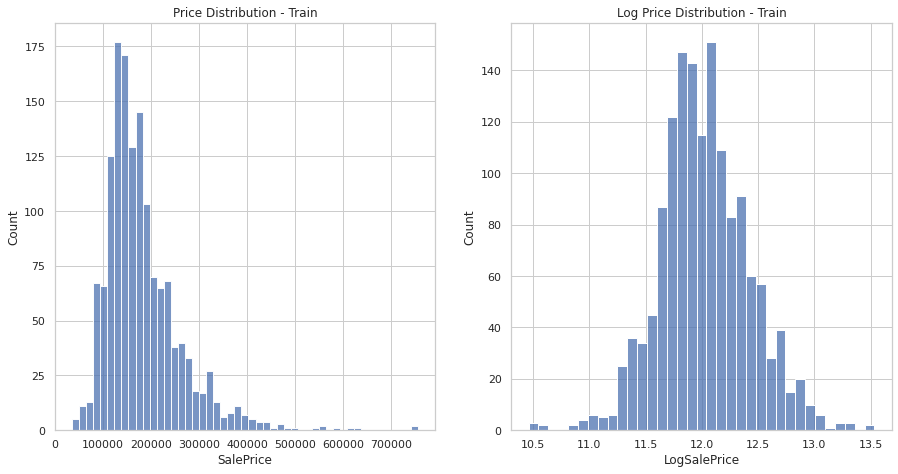

In [342]:
# Distribuição dos Preços das Casas
prices = train_data['SalePrice']
logPrices = np.log(prices)

fig, ax = plt.subplots(1, 2)
ax = ax.ravel()
hist_price = sbn.histplot(prices, ax=ax[0])
hist_logPrice = sbn.histplot(logPrices, ax=ax[1])

hist_price.set(title="Price Distribution - Train", ylabel="Count", xlabel="SalePrice")
hist_logPrice.set(title="Log Price Distribution - Train", ylabel="Count", xlabel="LogSalePrice")

fig.set_figwidth(15)
fig.set_figheight(7.5)
fig.savefig("./images/pricesDistributionsTrain.jpg")

---
O histograma à esquerda indica uma distribuição com *outliers* e não-centralizada. No histograma à direita, foi aplicada uma transformação logarítimica no atributo *SalePrice*, lidando com os *outliers* e normalizando a distribuição. Para treinamento do modelo, será utilizado o *SalePrice* com transformação logarítimica.

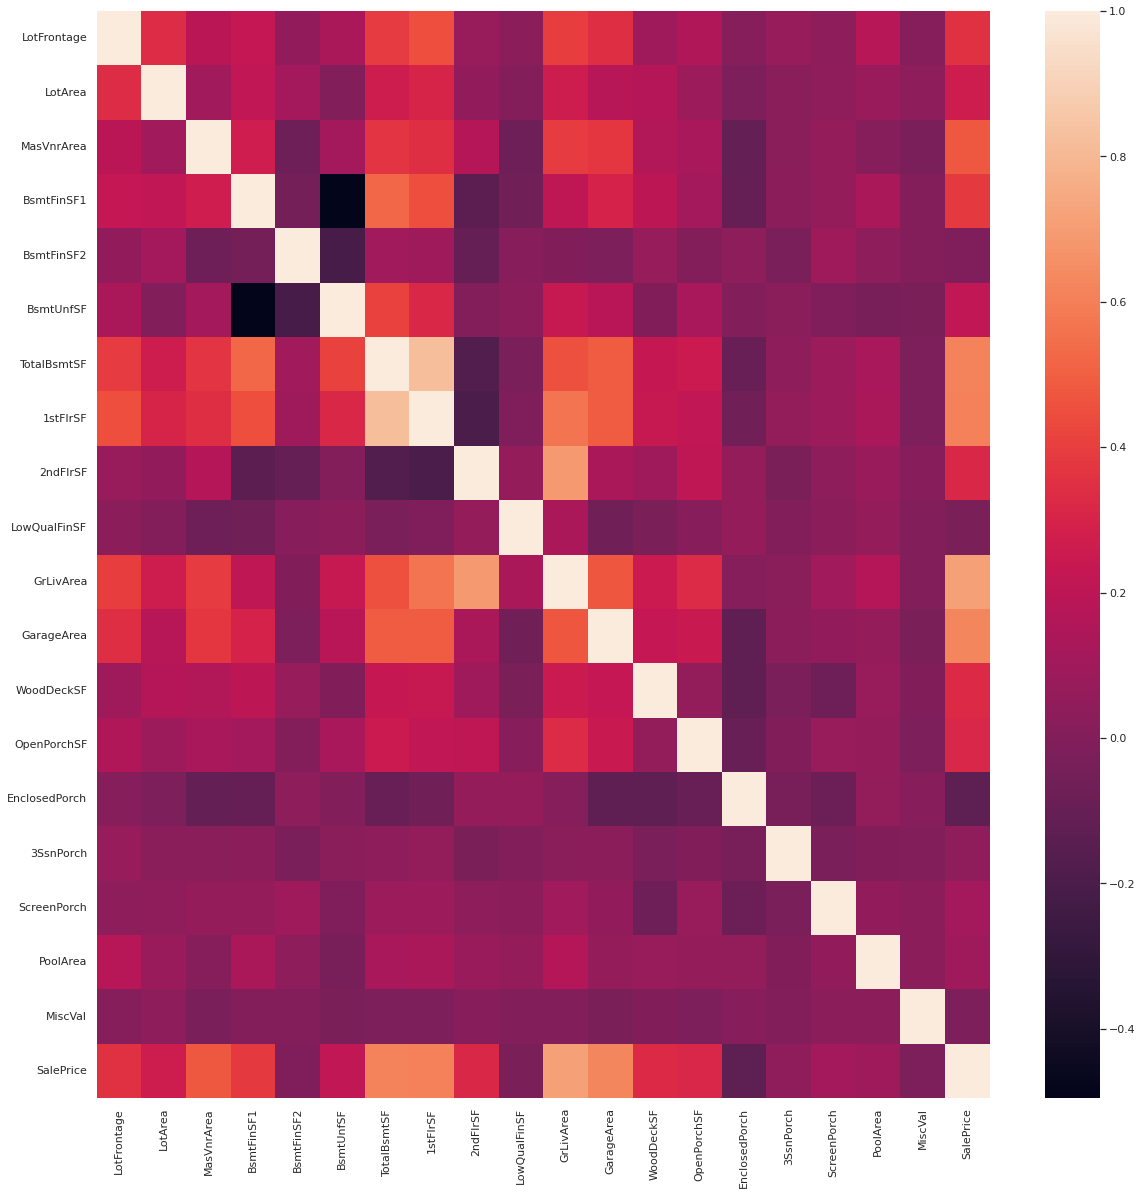

In [343]:
# Atributos Numéricos
train_data_numeric = train_data.select_dtypes([np.int64,np.float64]).loc[:, "LotFrontage":"SalePrice"]
# Correlações com os atributos numéricos
plt.figure(figsize=(20, 20))
sbn.heatmap(train_data_numeric .corr())
plt.savefig("./images/heatmapTrain.jpg")

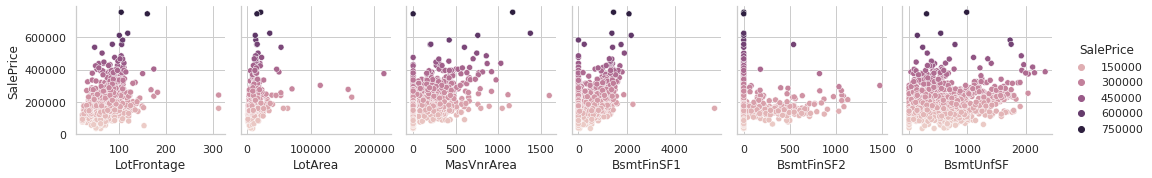

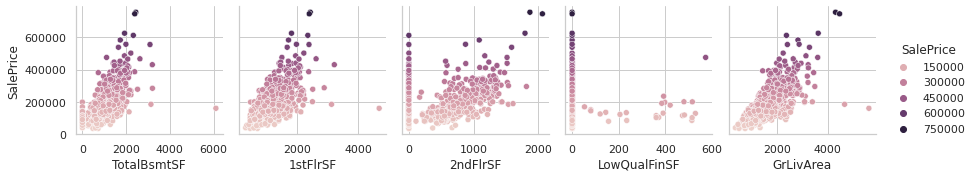

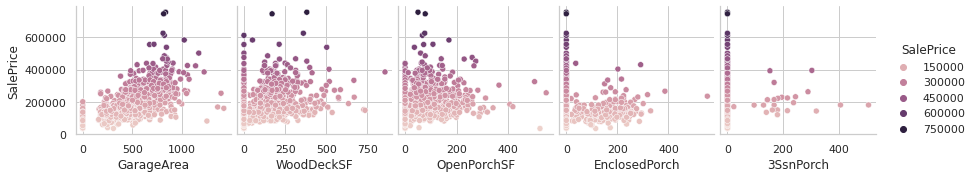

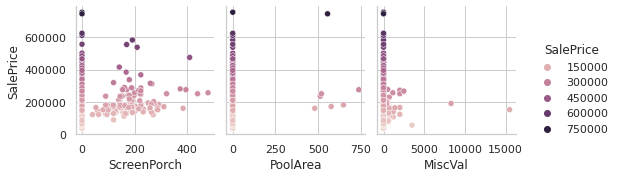

In [344]:
features = train_data_numeric.columns.values
sbn.pairplot(data=train_data_numeric, x_vars=features[0:6].tolist(), y_vars="SalePrice", hue="SalePrice");
plt.savefig("./images/pairplotTrainNumeric-I.jpg")
sbn.pairplot(data=train_data_numeric, x_vars=features[6:11].tolist(), y_vars="SalePrice", hue="SalePrice");
plt.savefig("./images/pairplotTrainNumeric-II.jpg")
sbn.pairplot(data=train_data_numeric, x_vars=features[11:16].tolist(), y_vars="SalePrice", hue="SalePrice");
plt.savefig("./images/pairplotTrainNumeric-III.jpg")
sbn.pairplot(data=train_data_numeric, x_vars=features[16:19].tolist(), y_vars="SalePrice", hue="SalePrice");
plt.savefig("./images/pairplotTrainNumeric-IV.jpg")

---
Nenhum padrão incomum foi observado, os atributos não têm forte correlação entre si e alguns deles tem forte relação linear com a variável objetivo.

### Treinamento dos Modelos

In [345]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [346]:
# Drop Id
train_processed, test_processed = train_data.drop(['Id', 'SalePrice'], 1), test_data.drop(['Id', 'SalePrice'], 1)
# Normalização z-score
scaler = StandardScaler()
scaler.fit(train_processed)
x_train = scaler.transform(train_processed)
x_test = scaler.transform(test_processed)
y_train = np.log(train_data['SalePrice'])

In [143]:
# Parâmetros da busca em rede
param_grid = {
        'activation': ['relu'],
        'hidden_layer_sizes': [(80, 120), (100, 100), (100, 120), (80, 80)],
        'solver': ['adam', 'sgd', 'lbfgs'],
        'learning_rate' : ['constant', 'adaptive'],
        'max_iter': [1000, 1200, 1500],
        'alpha': [0.1, 0.5, 0.01, 0.005, 0.0001]
         }

grid = GridSearchCV(estimator=MLPRegressor(), param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(x_train, y_train)

In [347]:
def write_results():
    print(f"Best: {round(grid_result.best_score_, 2)} using {grid_result.best_params_}")
    
    with open("scores.txt", "w") as file:
        file.write(f"Best: {round(grid_result.best_score_, 2)} using {grid_result.best_params_}\n")
        file.write("_"*150)
        file.write("\n")
        
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']
        for mean, stdev, param in zip(means, stds, params):
            file.write(f"{round(mean, 2)} ({stdev}) with: {param}\n")

write_results()

Best: 0.8 using {'activation': 'relu', 'alpha': 0.5, 'hidden_layer_sizes': (100, 120), 'learning_rate': 'adaptive', 'max_iter': 1000, 'solver': 'lbfgs'}


In [348]:
# DataFrame de resultados
df_eval = pd.DataFrame(grid.cv_results_)
df_eval.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_max_iter,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.937138,0.349500,0.006636,0.000481,relu,0.1,"(80, 120)",constant,1000,adam,"{'activation': 'relu', 'alpha': 0.1, 'hidden_l...",-6.554000,-7.269034,-7.172620,-8.682734,-8.062005,-7.548079,0.742777,92
1,8.207638,0.280969,0.006688,0.000427,relu,0.1,"(80, 120)",constant,1000,sgd,"{'activation': 'relu', 'alpha': 0.1, 'hidden_l...",-10.548775,-19.099876,-19.017867,-14.009306,-25.703883,-17.675941,5.148144,252
2,28.777000,0.763736,0.005443,0.000320,relu,0.1,"(80, 120)",constant,1000,lbfgs,"{'activation': 'relu', 'alpha': 0.1, 'hidden_l...",-1.123015,-2.247210,-2.146594,-1.253214,-1.465743,-1.647155,0.463104,38
3,5.800771,0.153441,0.005474,0.000494,relu,0.1,"(80, 120)",constant,1200,adam,"{'activation': 'relu', 'alpha': 0.1, 'hidden_l...",-6.587428,-6.722923,-7.316484,-7.067874,-8.942970,-7.327536,0.847407,85
4,7.728146,0.435525,0.005325,0.000444,relu,0.1,"(80, 120)",constant,1200,sgd,"{'activation': 'relu', 'alpha': 0.1, 'hidden_l...",-13.920476,-16.927825,-17.990095,-19.667029,-31.683205,-20.037726,6.116202,311


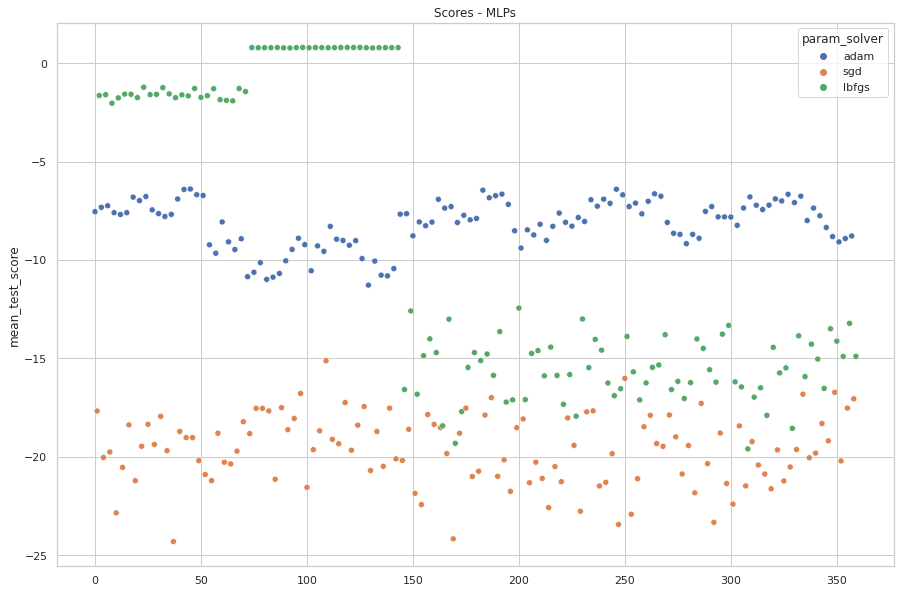

In [349]:
plt.figure(figsize=(15, 10))
scatter = sbn.scatterplot(data=df_eval, x=np.arange(df_eval.shape[0]), y="mean_test_score", hue="param_solver")
scatter.set(title="Scores - MLPs")
plt.savefig("./images/scoresMLPs.jpg")

In [350]:
# Predicton - best MLP
best_mlp = grid.best_estimator_
yhat_test = np.e**(best_mlp.predict(x_test))
yhat_train = np.e**(best_mlp.predict(x_train))


df_eval = pd.DataFrame()
df_eval["mlp-ytest"] = yhat_test
df_eval["mlp-ytrain"] = yhat_train[0:1459]
df_eval["SalePrice-Train"] = train_data['SalePrice'][0:1459]

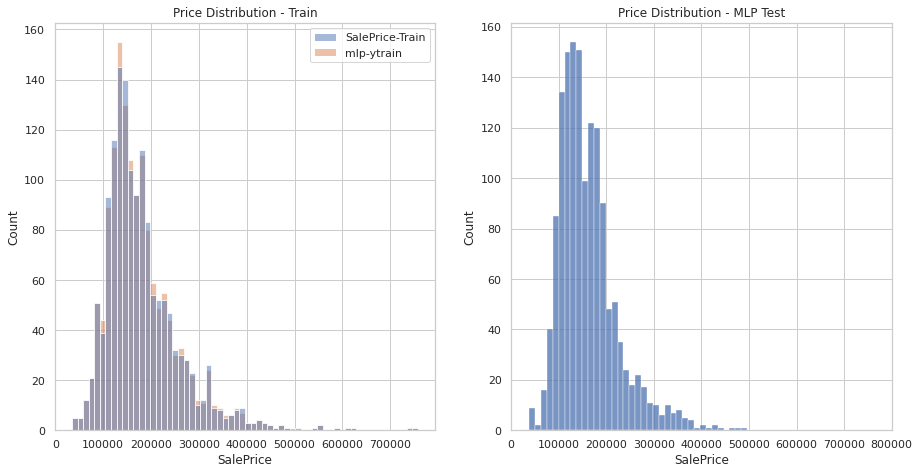

In [351]:
fig, ax = plt.subplots(1, 2)
ax = ax.ravel()
train_hist = sbn.histplot(df_eval[["SalePrice-Train","mlp-ytrain"]], ax=ax[0])
test_hist = sbn.histplot(df_eval["mlp-ytest"], ax=ax[1])

ax[1].set_xlim([0, 800000])

train_hist.set(title="Price Distribution - Train", ylabel="Count", xlabel="SalePrice")
test_hist.set(title="Price Distribution - MLP Test", ylabel="Count", xlabel="SalePrice")

fig.set_figwidth(15)
fig.set_figheight(7.5)
fig.savefig("./images/pricesDistributionsPredicted.jpg")

---
A busca em rede de Multilayer Preceptrons resultou em modelos com boa generalização, o melhor deles apresentou score igual a 0.8, isto é, o modelo explica 80% da variância da variável-objetivo. No gráfico de scores, são observadas quatro faixas bem definidas. A faixa com *scores* mais baixos contém modelos treinados por *sgd*, a faixa logo acima, representa uma parcela dos modelos treinados com *lbfgs*, em seguida a faixa do algoritimo *adam*, e finalmente, os melhores desempenhos foram obtidos pela parcela restante de modelos treinados com *lbfgs*.